In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# --- Langkah 1: Load Dataset ---
# Ganti 'loan_data.csv' dengan nama file dataset Anda
df = pd.read_csv("loan_data_train.csv")

# Tampilkan 5 baris pertama untuk memastikan struktur data
print("--- 5 Baris Pertama Data ---")
print(df.head())

--- 5 Baris Pertama Data ---
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural      

In [2]:
# --- Langkah 2: Pra-pemrosesan Data ---
# Drop kolom Loan_ID (tidak relevan untuk prediksi)
df = df.drop('Loan_ID', axis=1)

# Periksa apakah kolom target 'Loan_Status' ada
if 'Loan_Status' not in df.columns:
    raise ValueError("Kolom target 'Loan_Status' tidak ditemukan. Pastikan dataset Anda memiliki kolom ini.")

# Handle missing values
for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])  # Isi dengan modus

df['ApplicantIncome'] = df['ApplicantIncome'].fillna(df['ApplicantIncome'].median())
df['CoapplicantIncome'] = df['CoapplicantIncome'].fillna(df['CoapplicantIncome'].median())
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

# Encode variabel kategorikal
label_encoders = {}
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [3]:
# --- Langkah 3: Pisahkan Fitur dan Target ---
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']


In [4]:
# --- Langkah 4: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# --- Langkah 5: Latih Model Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediksi
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Akurasi training & testing
train_acc = rf_model.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n--- Hasil Training ---")
print(f"Akurasi Training: {train_acc:.4f}")
print(f"Akurasi Testing: {test_acc:.4f}")



--- Hasil Training ---
Akurasi Training: 1.0000
Akurasi Testing: 0.7561


In [6]:
# --- Langkah 6: Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Ditolak', 'Disetujui']))




--- Classification Report ---
              precision    recall  f1-score   support

     Ditolak       0.78      0.42      0.55        43
   Disetujui       0.75      0.94      0.83        80

    accuracy                           0.76       123
   macro avg       0.77      0.68      0.69       123
weighted avg       0.76      0.76      0.73       123



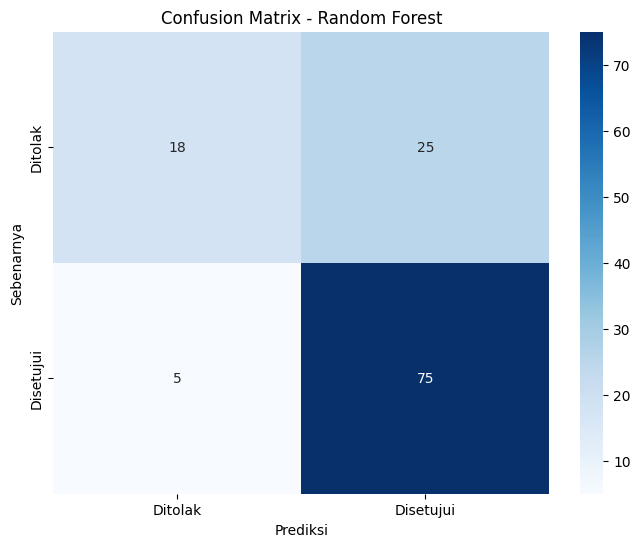

In [7]:
# --- Langkah 7: Confusion Matrix (Heatmap) ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ditolak', 'Disetujui'],
            yticklabels=['Ditolak', 'Disetujui'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')
plt.show()



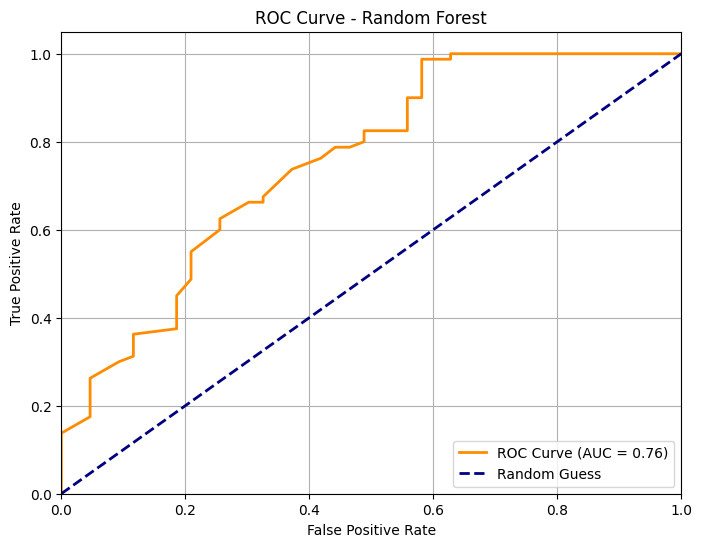

In [8]:
# --- Langkah 8: ROC Curve & AUC ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



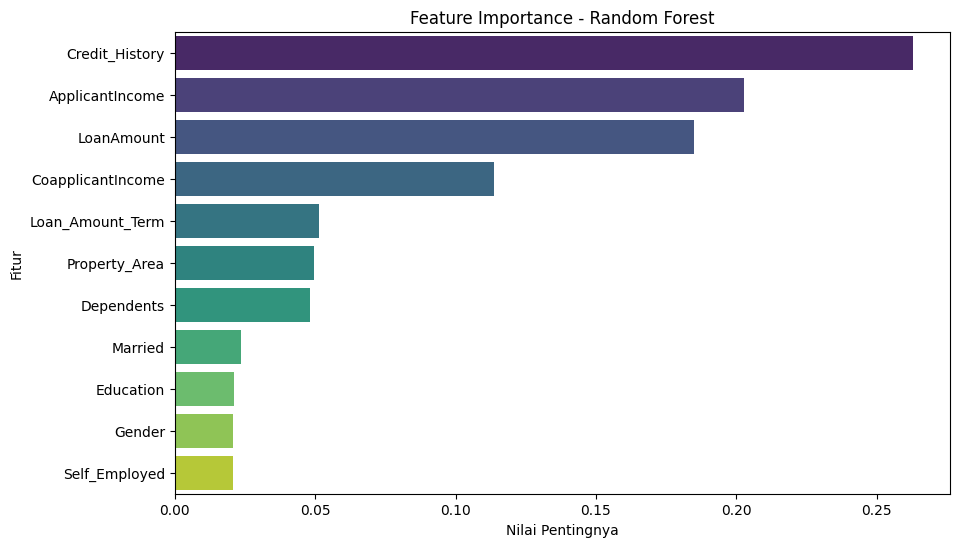

In [9]:
# --- Langkah 9: Feature Importance (Opsional tapi sangat berguna) ---
feature_importance_df = pd.DataFrame({
    'Fitur': X.columns,
    'Pentingnya': rf_model.feature_importances_
}).sort_values(by='Pentingnya', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Pentingnya', y='Fitur', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Nilai Pentingnya')
plt.ylabel('Fitur')
plt.show()

TP


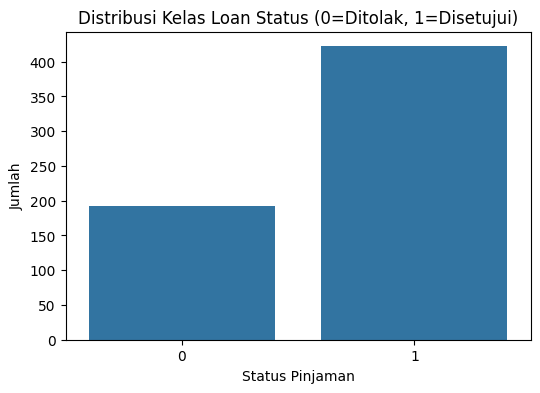

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Loan_Status', data=df)
plt.title('Distribusi Kelas Loan Status (0=Ditolak, 1=Disetujui)')
plt.xlabel('Status Pinjaman')
plt.ylabel('Jumlah')
plt.show()

In [12]:
# train_and_save_model.py
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import joblib

# Load dataset (ganti dengan file Anda)
df = pd.read_csv("loan_data_train.csv")

# Drop Loan_ID
df = df.drop('Loan_ID', axis=1)

# Handle missing values
for col in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History']:
    df[col] = df[col].fillna(df[col].mode()[0])
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

# Encode kategorikal
label_encoders = {}
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Simpan encoder untuk prediksi nanti
joblib.dump(label_encoders, 'label_encoders.pkl')

# Pisahkan fitur & target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Latih model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Simpan model
joblib.dump(rf, 'model.pkl')
print("✅ Model dan encoder berhasil disimpan!")

✅ Model dan encoder berhasil disimpan!
